In [1]:
import bittensor as bt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import bittensor as bt
import os.path
from multiprocessing import Pool as mp_Pool
import pandas as pd
import numpy as np
from substrateinterface import SubstrateInterface, Keypair

from scalecodec.utils.ss58 import ss58_encode
import matplotlib.pyplot as plt


from chain_status import ChainStatus
from simulation import ExperimentSetup, Experiments

from pympler import asizeof

from pool import Pool

In [2]:
foundation_hk = '5F4tQyWrhfGVcNhoqeiNsR6KjD4wMZ2kfhLj4oHYuyHbZAc3'
metagraph_storage_path = "./metagraphs"
block = 4130874

subtensor.block

4210648

## Supply analysis using on chain data
- change in token price and the convergence
- buying price at equilibrium 

In [11]:
exps = []
for buying_days in [90, 180]:
    for emission_strategy in ['regular', 'restricted']:
        exp = ExperimentSetup(days = 10, buying_days = buying_days, emission_strategy = emission_strategy, buying_strategy = 'scheduled', record_hk = [foundation_hk])
        exps.append(exp)

for limit in [2, 5, 10]:
    for emission_strategy in ['regular', 'restricted']:
        exp = ExperimentSetup(days = 10, buying_days = buying_days, emission_strategy = emission_strategy, buying_strategy = 'limit', limit = limit, buying_rate = 5e-3, record_hk = [foundation_hk])
        exps.append(exp)

exp_result = Experiments(block, metagraph_storage_path, exps).run()

/home/isabella/opentensor/research/dstao/chain_status.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  metas[netuid] = torch.load(file_name)


started ExperimentSetup(days=10, tempo=7200, block_time=12, init_subnet_strategy='sync_metagraph', subnet_weight=[], active_tao_rates=[], record_hk=['5F4tQyWrhfGVcNhoqeiNsR6KjD4wMZ2kfhLj4oHYuyHbZAc3'], emission_strategy='regular', price_regulation_factor=0.5, gamma=True, root_emission=1, buying_days=90, buying_rate=None, buying_strategy='scheduled', limit=5, sell=False, selling_rate=[])

started ExperimentSetup(days=10, tempo=7200, block_time=12, init_subnet_strategy='sync_metagraph', subnet_weight=[], active_tao_rates=[], record_hk=['5F4tQyWrhfGVcNhoqeiNsR6KjD4wMZ2kfhLj4oHYuyHbZAc3'], emission_strategy='restricted', price_regulation_factor=0.5, gamma=True, root_emission=1, buying_days=90, buying_rate=None, buying_strategy='scheduled', limit=5, sell=False, selling_rate=[])

started ExperimentSetup(days=10, tempo=7200, block_time=12, init_subnet_strategy='sync_metagraph', subnet_weight=[], active_tao_rates=[], record_hk=['5F4tQyWrhfGVcNhoqeiNsR6KjD4wMZ2kfhLj4oHYuyHbZAc3'], emission_stra

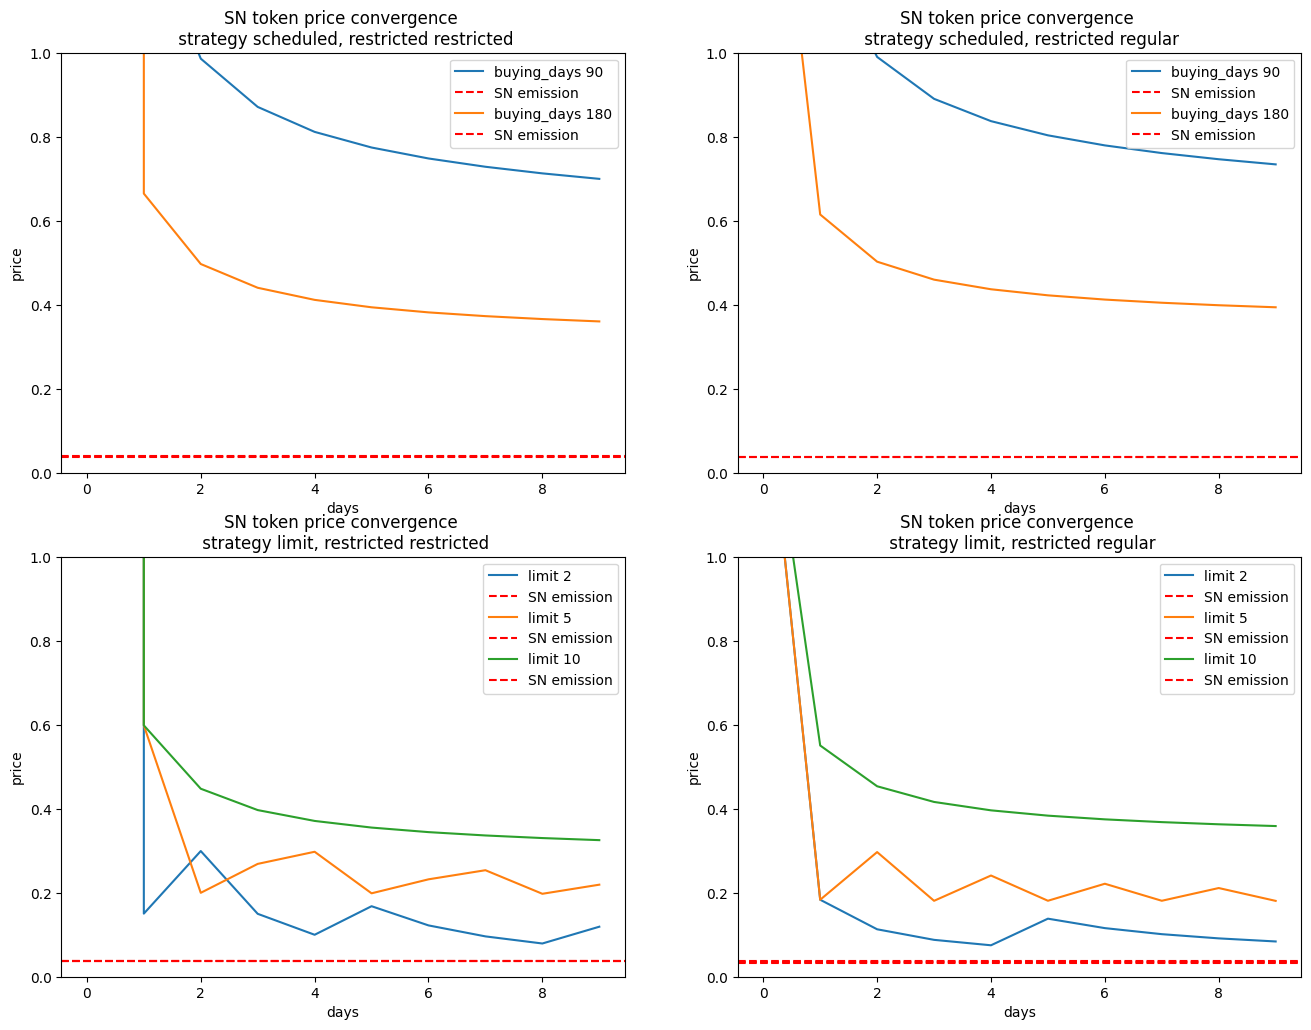

In [12]:
# (1) change in token price and the convergence

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
row = {'scheduled': 0, 'limit': 1} #strategy
col = {'restricted': 0, 'regular': 1} # restriced 

netuid = 1

for exp_id, results in exp_result.items():
    exp = results[0]
    results = results[1]
    alpha_price = []
    for i in range(len(results)):
        alpha_price.append(results[i]['pool'][netuid]['price'])

    if exp.buying_strategy == 'limit':
        label = f'limit {exp.limit}'
    elif exp.buying_strategy == 'scheduled':
        label = f'buying_days {exp.buying_days}'

    ax = axes[row[exp.buying_strategy], col[exp.emission_strategy]]
    ax.plot(alpha_price, label = label)
    ax.axhline(y = results[-1]['emission'][netuid] , color = 'r', linestyle = '--', label = 'SN emission')
    ax.set_title(f'SN token price convergence \n strategy {exp.buying_strategy}, restricted {exp.emission_strategy}')

    ax.set_ylabel('price')
    ax.set_xlabel('days')
    ax.set_ylim(0, 1)
    ax.legend()

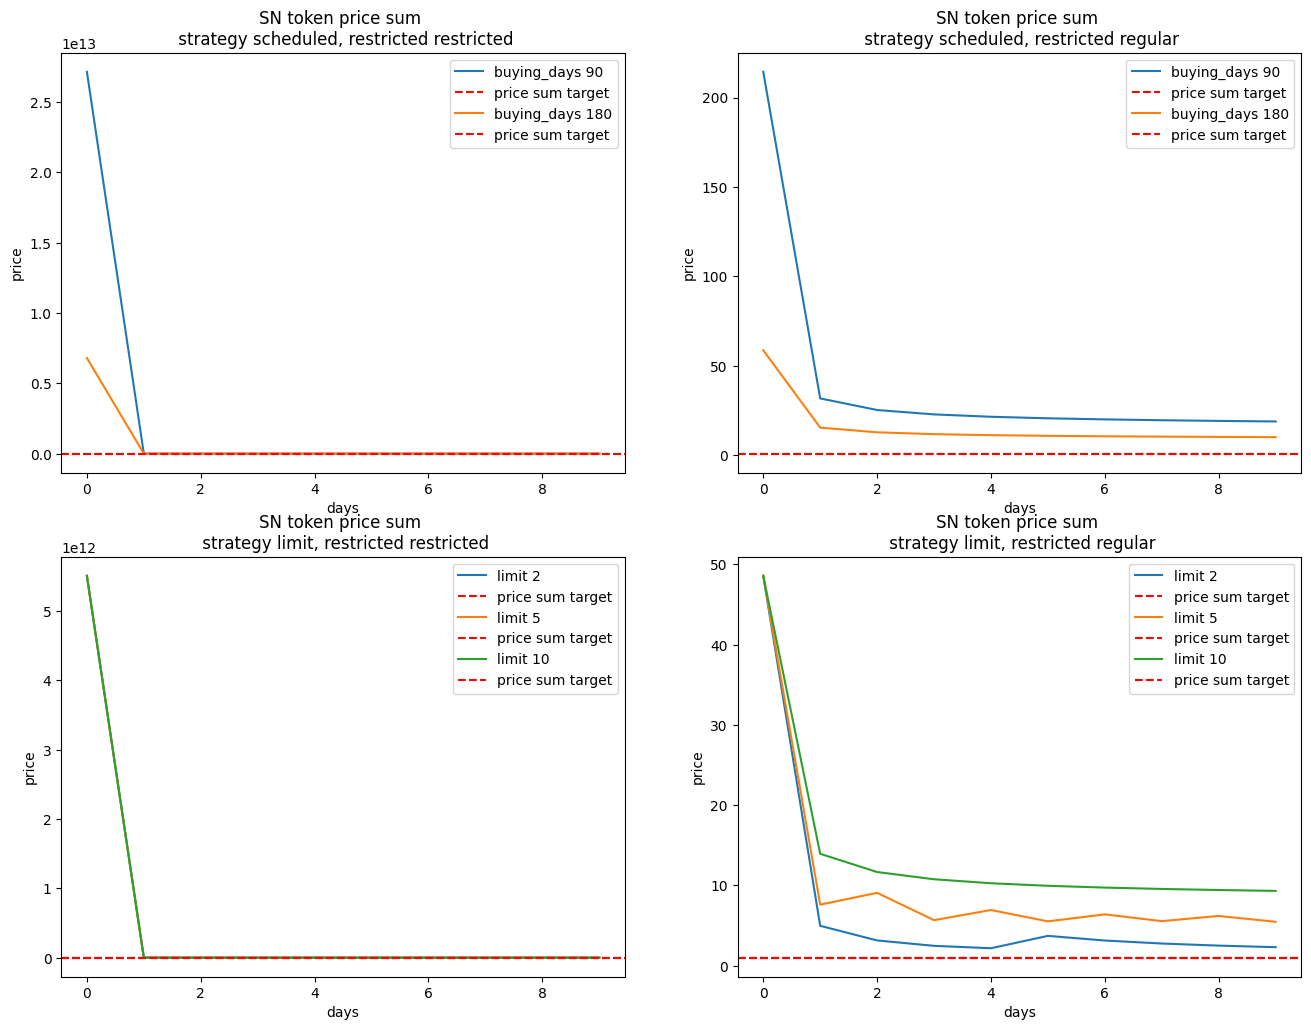

In [19]:
# (1) mark tao emission

import matplotlib.colors as mcolors
colors = mcolors.TABLEAU_COLORS

netuid = 1

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

for exp_id, results in exp_result.items():
    exp = results[0]
    results = results[1]
    price_sums = []

    for result in results: # for each tempo
        prices_sum = 0 
        for netuid, pool in result['pool'].items():
            prices_sum += pool['price']

        price_sums.append(prices_sum)

    if exp.buying_strategy == 'limit':
        label = f'limit {exp.limit}'
    elif exp.buying_strategy == 'scheduled':
        label = f'buying_days {exp.buying_days}'

    ax = axes[row[exp.buying_strategy], col[exp.emission_strategy]]
    ax.plot(price_sums, label = label)
    ax.axhline(y = 1, color = 'r', linestyle = '--', label = 'price sum target')
    ax.set_title(f'SN token price sum \n strategy {exp.buying_strategy}, restricted {exp.emission_strategy}')
    
    ax.set_ylabel('price')
    ax.set_xlabel('days')
    # ax.set_ylim(0, 10)
    ax.legend()

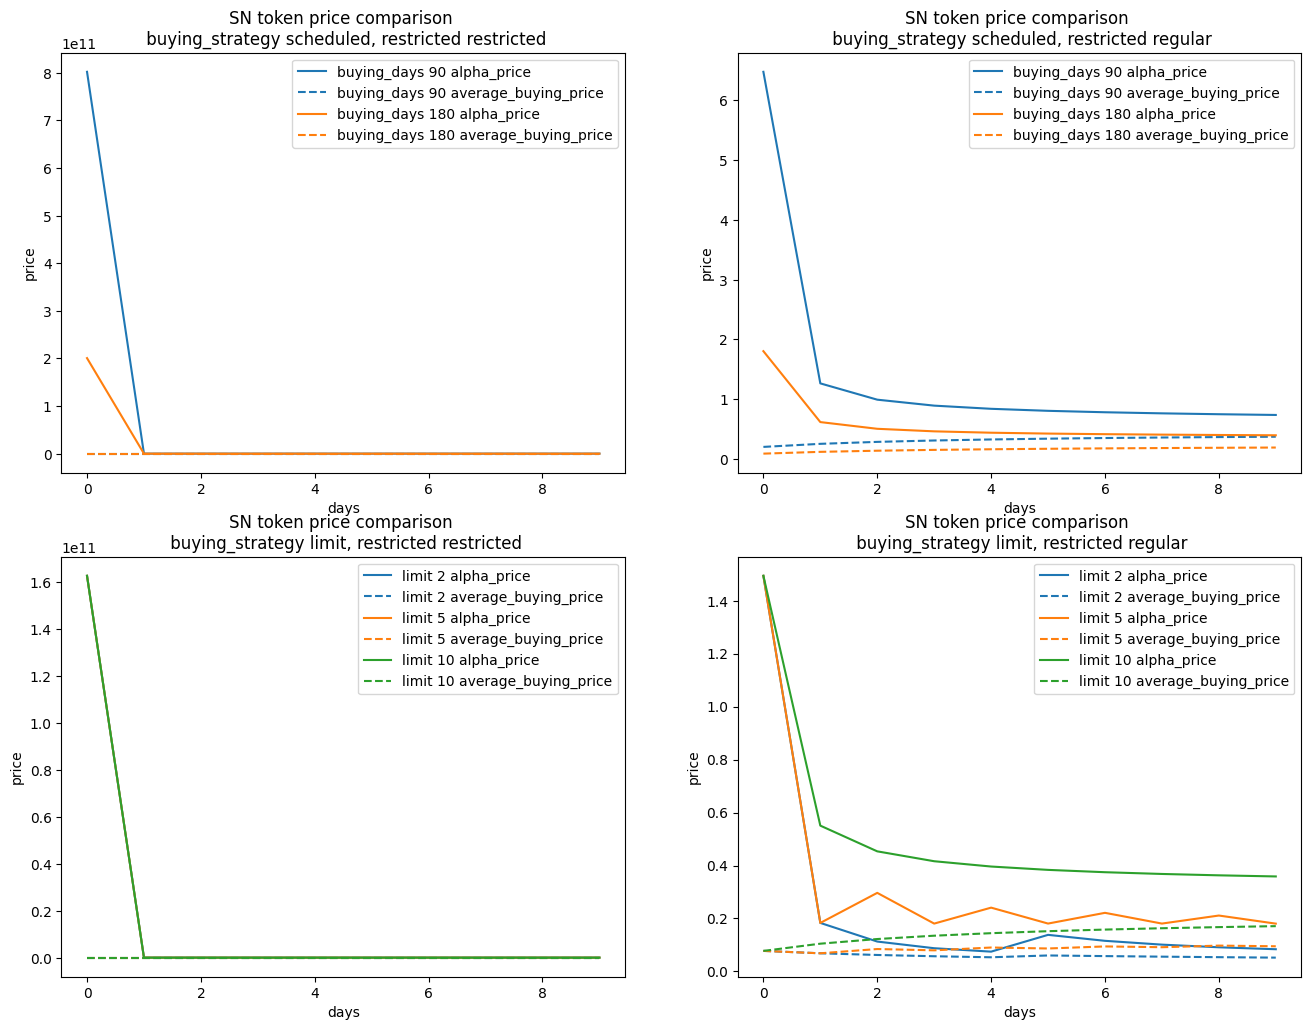

In [20]:
# (2) buying price at equilibrium 

# so it means that the assumption of "get in early so that you can mine early alpha" is not there if everyone is participating 
# need to test again when some people is not participating

netuid = 1

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

for exp_id, results in exp_result.items():
    exp = results[0]
    results = results[1]
    alpha_price = []
    average_buying_price = []
    SN_tao_spent = []
    SN_token = []
    for i in range(len(results)):
        w = results[i]['wallet_status'][foundation_hk]
        SN_tao_spent.append(w['SN_tao_spent'][netuid])
        SN_token.append(w['SN_token'][netuid])
        average_buying_price.append(( w['SN_tao_spent'][netuid] / w['SN_token'][netuid]) * -1)
        alpha_price.append(results[i]['pool'][netuid]['price'])

    if exp.buying_strategy == 'limit':
        label = f'limit {exp.limit}'
    elif exp.buying_strategy == 'scheduled':
        label = f'buying_days {exp.buying_days}'

    ax = axes[row[exp.buying_strategy], col[exp.emission_strategy]]
    line1, = ax.plot(alpha_price, label = label + ' alpha_price')
    ax.plot(average_buying_price, linestyle = '--', color = line1.get_color(), label = label + ' average_buying_price')
    ax.set_title(f'SN token price comparison \n buying_strategy {exp.buying_strategy}, restricted {exp.emission_strategy}')
    ax.set_ylabel('price')
    ax.set_xlabel('days')
    # ax.set_ylim(0, 0.6)
    ax.legend()

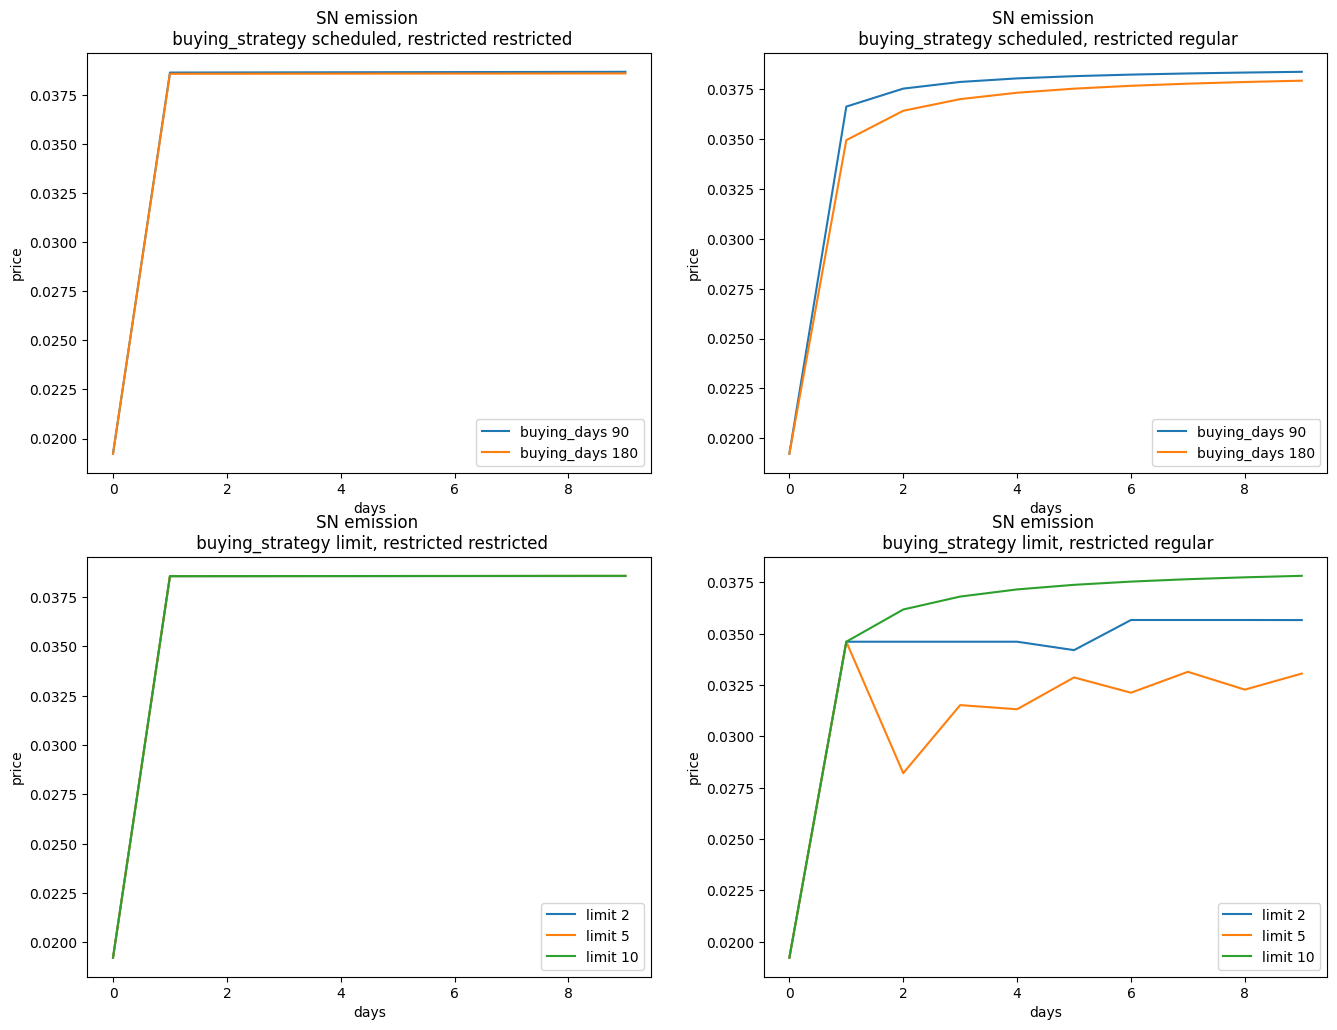

In [21]:
netuid = 1

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

for exp_id, results in exp_result.items():
    exp = results[0]
    results = results[1]
    emission = []
    for result in results:
        emission.append( result['emission'][netuid])

    if exp.buying_strategy == 'limit':
        label = f'limit {exp.limit}'
    elif exp.buying_strategy == 'scheduled':
        label = f'buying_days {exp.buying_days}'

    ax = axes[row[exp.buying_strategy], col[exp.emission_strategy]]
    ax.plot(emission, label = label)
    ax.set_title(f'SN emission \n buying_strategy {exp.buying_strategy}, restricted {exp.emission_strategy}')
    ax.set_ylabel('price')
    ax.set_xlabel('days')
    # ax.set_ylim(0.04, 0.055)
    ax.legend()

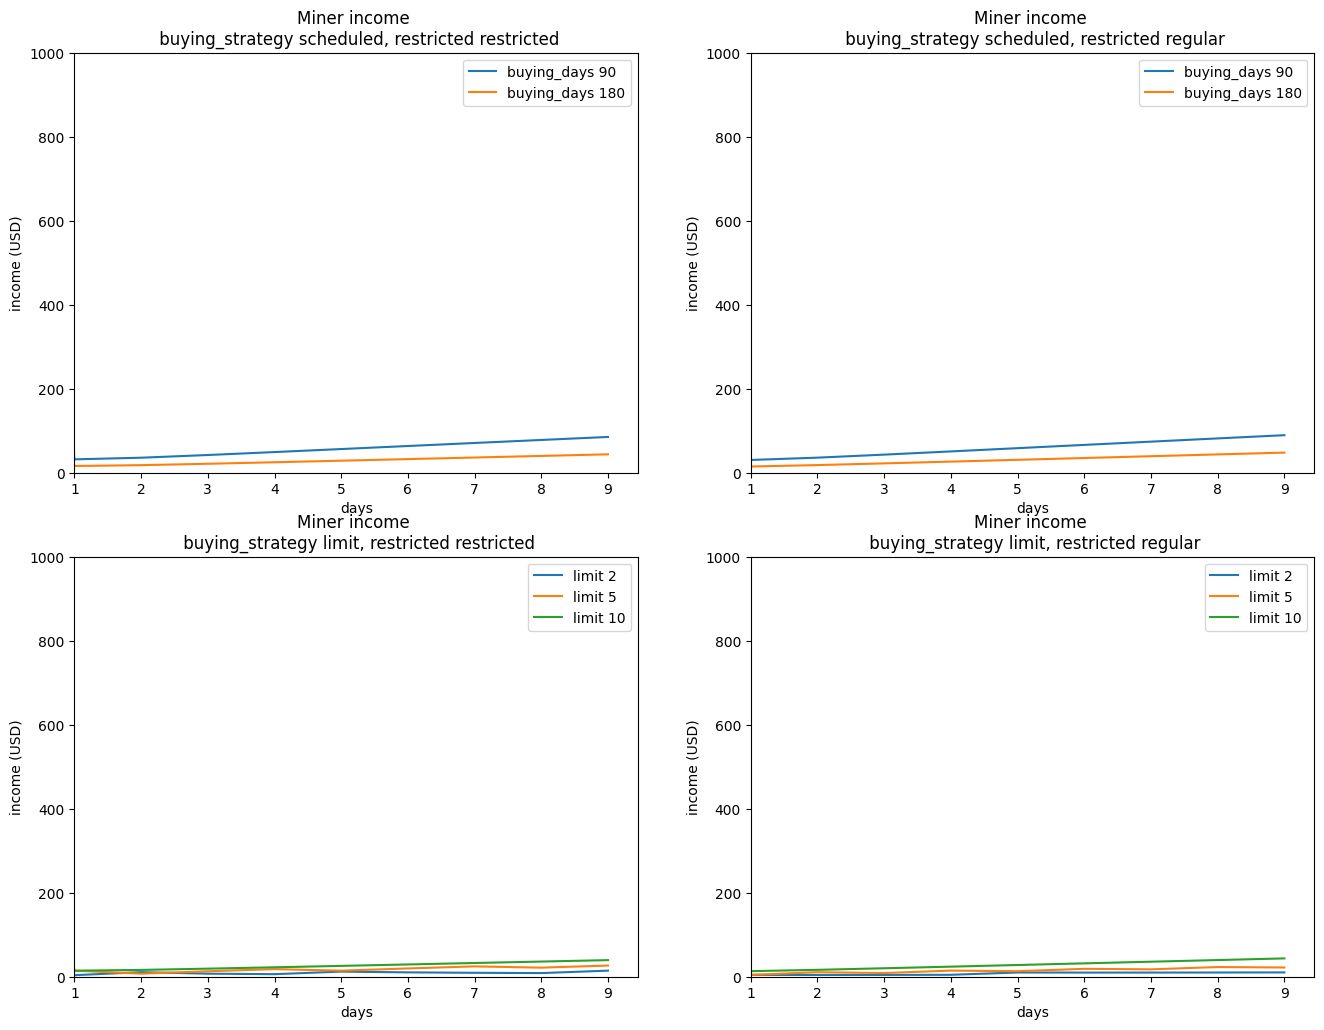

In [22]:
# (3) miner's income

netuid = 4
miners = []
def find_miner(result, netuid):
    for hk, w in result['wallet_status'].items():
        if netuid in w['SN_role'] and w['SN_role'][netuid] == 'miner':
            return hk

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

for exp_id, results in exp_result.items():
    exp = results[0]
    results = results[1]
    miner_hk = find_miner(results[0], netuid)
    miners.append(miner_hk)
    miner_income = []
    alphas = []
    for i in range(len(results)):
        w = results[i]['wallet_status'][miner_hk]
        p = Pool(netuid = netuid)
        p.from_dict(results[i]['pool'][netuid])
        alpha = w['SN_token'][netuid]
        alphas.append(alpha)
        miner_income.append(p.simsell(alpha))

    # plt.plot(miner_income, label = f'buying period {exp.buying_days} days, restricted {exp.restricted}')
    
    if exp.buying_strategy == 'limit':
        label = f'limit {exp.limit}'
    elif exp.buying_strategy == 'scheduled':
        label = f'buying_days {exp.buying_days}'

    ax = axes[row[exp.buying_strategy], col[exp.emission_strategy]]
    ax.plot(miner_income, label = label)
    ax.set_title(f'Miner income \n buying_strategy {exp.buying_strategy}, restricted {exp.emission_strategy}')
    ax.set_ylabel('income (USD)')
    ax.set_xlabel('days')
    ax.set_xlim(1)
    ax.legend()

for ax in axes.flat:
    ax.set_ylim(0, 1000)

## Selling pressure analysis
- miner's income 

In [24]:
exps2 = []
for selling_rate in [0.2, 0.5, 0.8]:
    exp = ExperimentSetup( 
        emission_strategy = 'restricted', 
        init_subnet_strategy = 'create',
        subnet_weight = [0.3, 0.3, 0.3],
        buying_strategy = 'limit', 
        limit = 5, 
        buying_rate = 5e-3,
        sell = True,
        selling_rate = [selling_rate, selling_rate/2 ,0] )
    exps2.append(exp)

exp_result2 = Experiments(block, metagraph_storage_path, exps2).run()

/home/isabella/opentensor/research/dstao/chain_status.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  metas[netuid] = torch.load(file_name)


started ExperimentSetup(days=365, tempo=7200, block_time=12, init_subnet_strategy='create', subnet_weight=[0.3, 0.3, 0.3], active_tao_rates=[], record_hk=[], emission_strategy='restricted', price_regulation_factor=0.5, gamma=True, root_emission=1, buying_days=30, buying_rate=0.005, buying_strategy='limit', limit=5, sell=True, selling_rate=[0.2, 0.1, 0])

started ExperimentSetup(days=365, tempo=7200, block_time=12, init_subnet_strategy='create', subnet_weight=[0.3, 0.3, 0.3], active_tao_rates=[], record_hk=[], emission_strategy='restricted', price_regulation_factor=0.5, gamma=True, root_emission=1, buying_days=30, buying_rate=0.005, buying_strategy='limit', limit=5, sell=True, selling_rate=[0.5, 0.25, 0])

started ExperimentSetup(days=365, tempo=7200, block_time=12, init_subnet_strategy='create', subnet_weight=[0.3, 0.3, 0.3], active_tao_rates=[], record_hk=[], emission_strategy='restricted', price_regulation_factor=0.5, gamma=True, root_emission=1, buying_days=30, buying_rate=0.005, bu

/tmp/ipykernel_2481313/598289274.py:15: MatplotlibDeprecationWarning: Passing label as a length 3 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(alpha_price, label = exp.selling_rate)


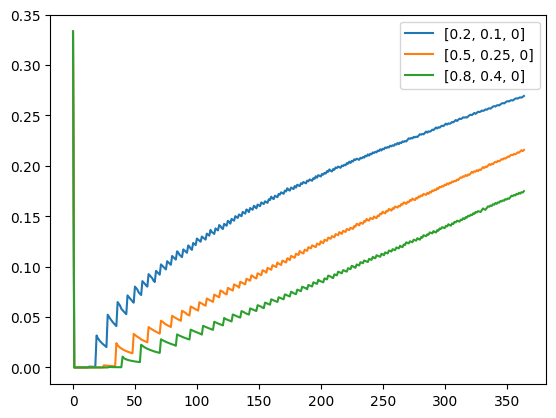

In [39]:
# (1) change in token price and the convergence
row = {'scheduled': 0, 'limit': 1} #strategy
col = {True: 0, False: 1} # restriced 

netuid = 1

for exp_id, results in exp_result2.items():
    exp = results[0]
    results = results[1]
    alpha_price = []

    for result in results:
        alpha_price.append(result['emission'][netuid])

    plt.plot(alpha_price, label = exp.selling_rate)

# plt.ylim(0, 0.005)
plt.legend()

In [18]:
# apy for ppl buying VS not buying with gamma

In [14]:
[f'validator_{i}'for i in range(3)]

(['validator_0', 'validator_1', 'validator_2'],)

## APY for NoOpt

In [3]:
exps3 = []
exps3.append(ExperimentSetup( 
    # timing
    days = 365 * 4,
    tempo = 7200 *4,

    # create subnets
    init_subnet_strategy = 'create',
    subnet_weight = [0.05, 0.3, 0.65],
    
    # create hotkeys
    active_tao_rates = [0.5, 1, 0.5, 0],
    record_hk = ['owner_0'] + [f'validator_{i}'for i in range(1, 4)],
    
    # buying
    buying_strategy = 'limit', 
    limit = 5, 
    
    # selling
    sell = False,
    
    # emission
    emission_strategy = 'restricted', 

    gamma = False
))


exps3.append(ExperimentSetup( 
    days = 365 * 4,
    tempo = 7200 * 4,
    # create subnets
    init_subnet_strategy = 'create',
    subnet_weight = [0.05, 0.3, 0.65],
    
    # create hotkeys
    active_tao_rates = [0.5, 1, 0.5, 0],
    record_hk = ['owner_0'] + [f'validator_{i}'for i in range(1, 4)],
    
    # buying
    buying_strategy = 'limit', 
    limit = 1.1, 
    
    # selling
    sell = False,
    
    # emission
    emission_strategy = 'price_regulation', 
    price_regulation_factor = 1,
    gamma = False
))

exps3.append(ExperimentSetup( 
    days = 365 * 4,
    tempo = 7200 *4,
    # create subnets
    init_subnet_strategy = 'create',
    subnet_weight = [0.05, 0.3, 0.65],
    
    # create hotkeys
    active_tao_rates = [0.5, 1, 0.5, 0],
    record_hk = ['owner_0'] + [f'validator_{i}'for i in range(1, 4)],
    
    # buying
    buying_strategy = 'limit', 
    limit = 1.1, 
    
    # selling
    sell = False,
    
    # emission
    emission_strategy = 'price_regulation', 
    price_regulation_factor = 1,
    gamma = False,
    root_emission = 0.5
))

exps3.append(ExperimentSetup( 
    days = 365 * 4,
    tempo = 7200 * 4,
    # create subnets
    init_subnet_strategy = 'create',
    subnet_weight = [0.05, 0.3, 0.65],
    
    # create hotkeys
    active_tao_rates = [0.5, 1, 0.5, 0],
    record_hk = ['owner_0'] + [f'validator_{i}'for i in range(1, 4)],
    
    # buying
    buying_strategy = 'limit', 
    limit = 1.1, 
    
    # selling
    sell = False,
    
    # emission
    emission_strategy = 'price_regulation', 
    price_regulation_factor = 1,
    gamma = False,
    root_emission = 0
))


exp_result3 = Experiments(block, metagraph_storage_path, exps3).run()
# [the exp][set up or result][tempo]

/home/isabella/opentensor/research/dstao/chain_status.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  metas[netuid] = torch.load(file_name)


started ExperimentSetup(days=1460, tempo=28800, block_time=12, init_subnet_strategy='create', subnet_weight=[0.05, 0.3, 0.65], active_tao_rates=[0.5, 1, 0.5, 0], record_hk=['owner_0', 'validator_1', 'validator_2', 'validator_3'], emission_strategy='restricted', price_regulation_factor=0.5, gamma=False, root_emission=1, buying_days=30, buying_rate=None, buying_strategy='limit', limit=5, sell=False, selling_rate=[])

started ExperimentSetup(days=1460, tempo=28800, block_time=12, init_subnet_strategy='create', subnet_weight=[0.05, 0.3, 0.65], active_tao_rates=[0.5, 1, 0.5, 0], record_hk=['owner_0', 'validator_1', 'validator_2', 'validator_3'], emission_strategy='price_regulation', price_regulation_factor=1, gamma=False, root_emission=1, buying_days=30, buying_rate=None, buying_strategy='limit', limit=1.1, sell=False, selling_rate=[])

started ExperimentSetup(days=1460, tempo=28800, block_time=12, init_subnet_strategy='create', subnet_weight=[0.05, 0.3, 0.65], active_tao_rates=[0.5, 1, 0.5

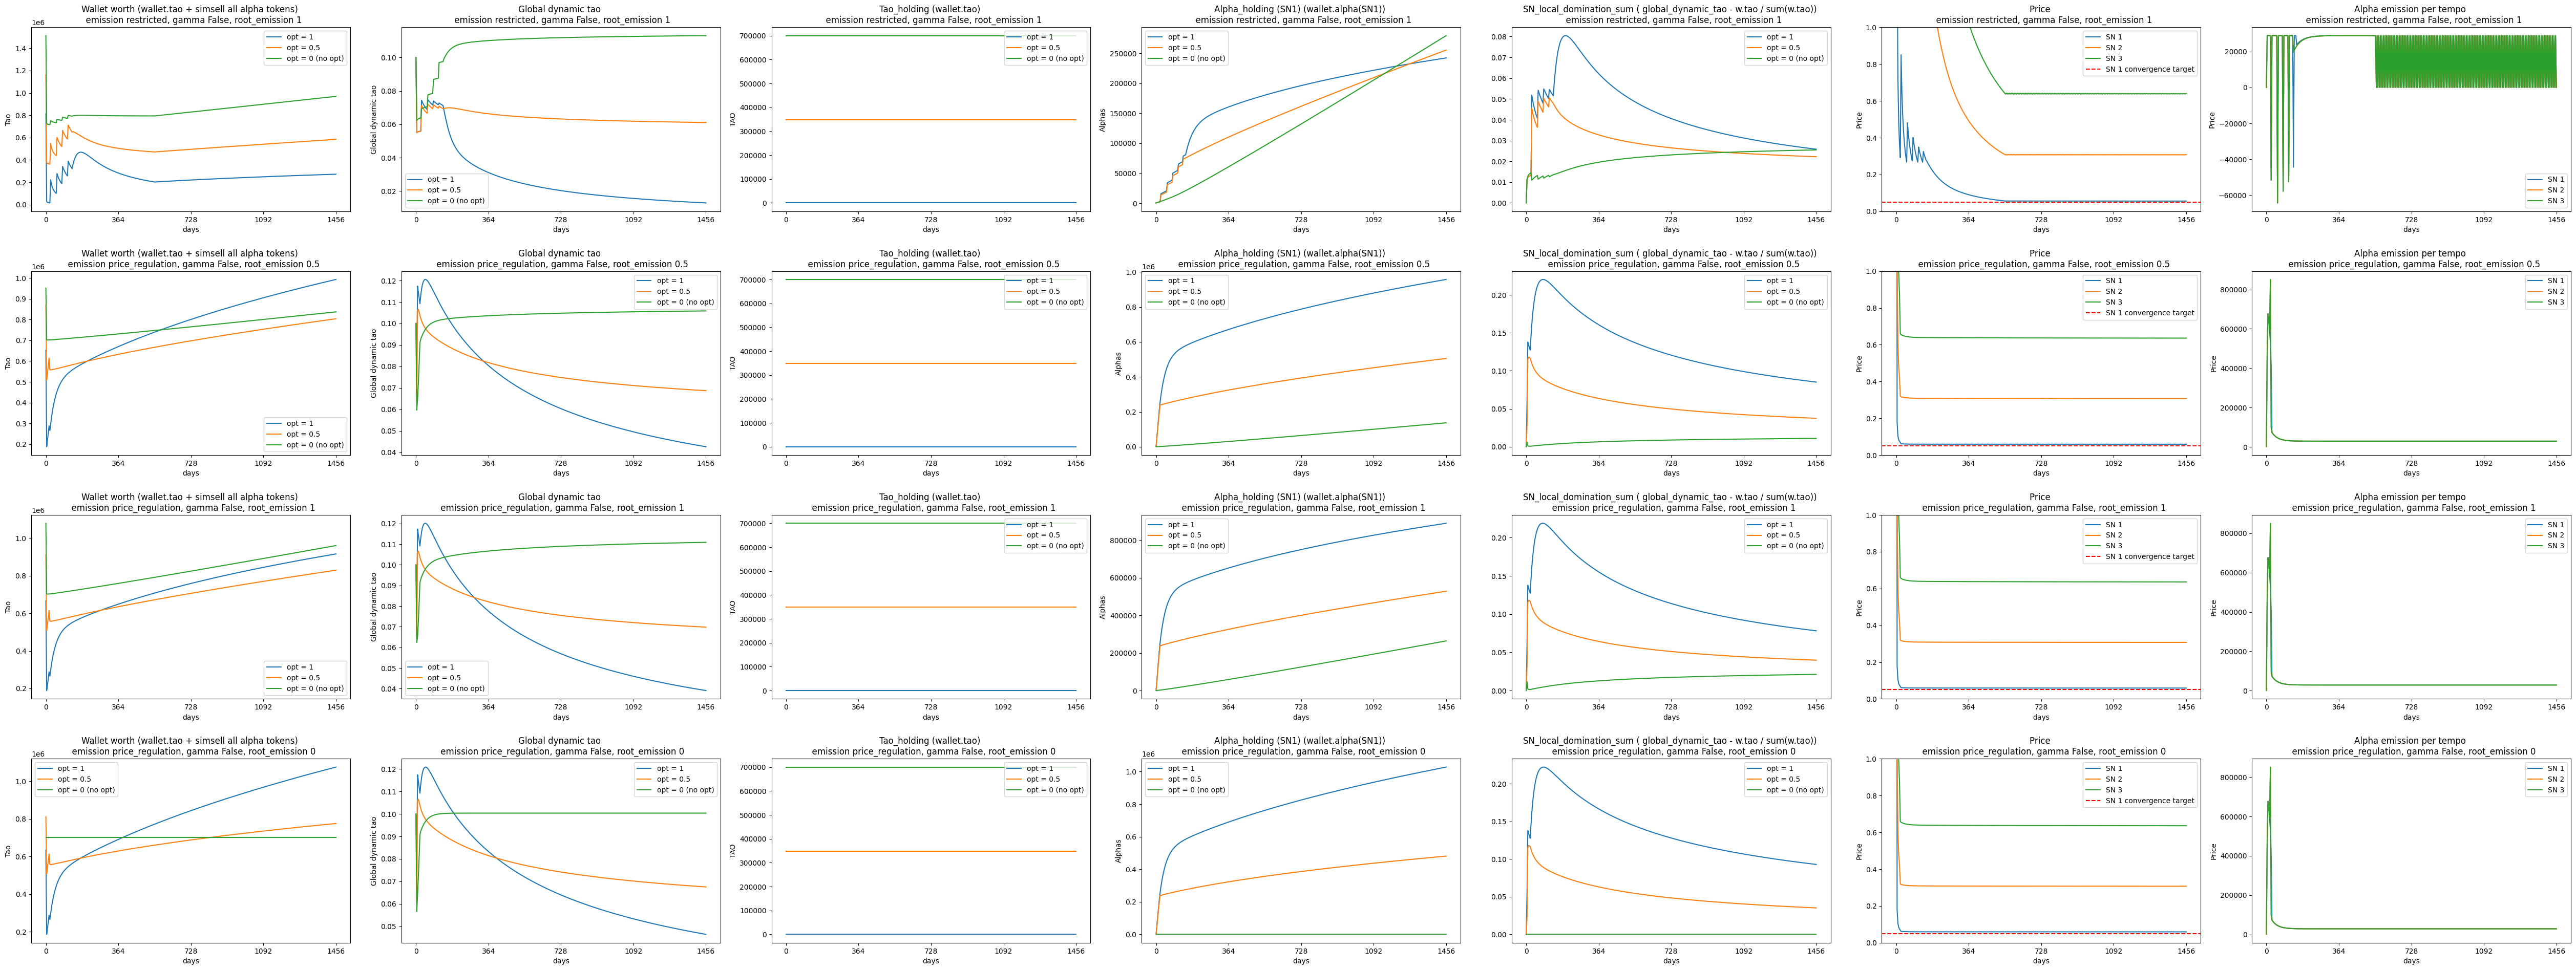

In [5]:
ncols = 7
nrows = len(exp_result3)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 6 * 1.2, nrows * 4 * 1.2 ))

# row = {'restricted': 0, 'price_regulation': 1} #strategy
row = 0
col = {'global_dynamic_tao': 1, 'wallet_worth': 0, 'tao_holding':2 ,'alpha_holding':3, 'SN_local_domination_sum':4, 'price':5, 'alpha_emission':6} # restriced 

hk_opt = {
    'validator_1': 'opt = 1',
    'validator_2': 'opt = 0.5',
    'validator_3': 'opt = 0 (no opt)',

} 

for exp_idx, results in exp_result3.items():
    exp = results[0]
    results = results[1]
    global_dynamic_tao = {}
    wallet_worth = {}
    tao_holding = {}
    alpha_holding = {}
    SN_local_domination_sum = {}
    prices = {}
    alpha_in = {}
    alpha_emission = {}

    for result in results: # each tempo
        pools = []
        for netuid, pool_dict in result['pool'].items():
            p = Pool(netuid = netuid)
            p.from_dict(pool_dict)
            pools.append(p)
            
            if netuid not in prices:
                prices[netuid] = []
                alpha_in[netuid] = [0]
                alpha_emission[netuid] = []
            
            prices[netuid].append(p.price)
            alpha_in[netuid].append(p.alpha_in)
            alpha_emission[netuid].append(alpha_in[netuid][-1] - alpha_in[netuid][-2])


        for hk, w in result['wallet_status'].items():
            if hk not in [f'validator_{i}'for i in range(1, 4)]:
                continue
            if hk not in global_dynamic_tao:
                global_dynamic_tao[hk] = []
                wallet_worth[hk] = []
                tao_holding[hk] = []
                alpha_holding[hk] = []
                SN_local_domination_sum[hk] = []
                
            global_dynamic_tao[hk].append(w['global_dynamic_tao'])
            wallet_worth[hk].append(w['tao'] + sum([ p.simsell(d) for p, d in zip (pools, w['SN_token'])]) )
            tao_holding[hk].append(w['tao'])
            alpha_holding[hk].append(w['SN_token'][0])
            SN_local_domination_sum[hk].append(w['SN_local_domination_sum'])


    exp_str = f"emission {exp.emission_strategy}, gamma {exp.gamma}, root_emission {exp.root_emission}" 
    ax = axes[row, col['global_dynamic_tao']] 
    for hk, worth in global_dynamic_tao.items():
        ax.plot(worth, label = hk_opt[hk])

    ax.set_title(f'Global dynamic tao \n {exp_str}')
    ax.set_ylabel('Global dynamic tao')
    ax.set_xlabel('days')
    ax.legend()
    ax.set_xticks(np.arange(365), labels = np.arange(365) * 4)
    ax.set_xticks(ax.get_xticks()[::91])
    
    ax = axes[row, col['wallet_worth']] 
    for hk, worth in wallet_worth.items():
        ax.plot(worth, label = hk_opt[hk])
    
    ax.set_title(f'Wallet worth (wallet.tao + simsell all alpha tokens) \n  {exp_str}')
    ax.set_ylabel('Tao')
    ax.set_xlabel('days')
    ax.legend()
    ax.set_xticks(np.arange(365), labels = np.arange(365) * 4)
    ax.set_xticks(ax.get_xticks()[::91])

    ax = axes[row, col['tao_holding']]
    for hk, worth in tao_holding.items():
        ax.plot(worth, label = hk_opt[hk])
    
    ax.set_title(f'Tao_holding (wallet.tao) \n  {exp_str}')
    ax.set_ylabel('TAO')
    ax.set_xlabel('days')
    ax.legend()
    ax.set_xticks(np.arange(365), labels = np.arange(365) * 4)
    ax.set_xticks(ax.get_xticks()[::91])

    ax = axes[row, col['alpha_holding']]
    for hk, worth in alpha_holding.items():
        ax.plot(worth, label = hk_opt[hk])
    
    ax.set_title(f'Alpha_holding (SN1) (wallet.alpha(SN1)) \n  {exp_str}')
    ax.set_ylabel('Alphas')
    ax.set_xlabel('days')
    ax.legend()
    ax.set_xticks(np.arange(365), labels = np.arange(365) * 4)
    ax.set_xticks(ax.get_xticks()[::91])

    ax = axes[row, col['SN_local_domination_sum']]
    for hk, worth in SN_local_domination_sum.items():
        ax.plot(worth, label = hk_opt[hk])
    
    ax.set_title(f'SN_local_domination_sum ( global_dynamic_tao - w.tao / sum(w.tao)) \n  {exp_str}')
    ax.set_ylabel('')
    ax.set_xlabel('days')
    ax.legend()
    ax.set_xticks(np.arange(365), labels = np.arange(365) * 4)
    ax.set_xticks(ax.get_xticks()[::91])

    ax = axes[row, col['price']] 
    for netuid, worth in prices.items():
        ax.plot(worth, label = f"SN {netuid + 1}")

    ax.axhline(y=0.05, color='r', linestyle='--', label='SN 1 convergence target')
    
    ax.set_title(f'Price \n  {exp_str}')
    ax.set_ylabel('Price')
    ax.set_xlabel('days')
    ax.set_ylim(0, 1)
    ax.legend()
    ax.set_xticks(np.arange(365), labels = np.arange(365) * 4)
    ax.set_xticks(ax.get_xticks()[::91])

    ax = axes[row, col['alpha_emission']] 
    for netuid, worth in alpha_emission.items():
        ax.plot(worth, label = f"SN {netuid + 1}")

    ax.set_title(f'Alpha emission per tempo \n  {exp_str}')
    ax.set_ylabel('Price')
    ax.set_xlabel('days')
    ax.legend()
    ax.set_xticks(np.arange(365), labels = np.arange(365) * 4)
    ax.set_xticks(ax.get_xticks()[::91])
    row += 1

plt.tight_layout()

In [9]:
# another reason for low earning is that buying local alpha decreases global dynamic tao and thus earning in multiple SNs 